# Disaster Tweet Prediction

In [ ]:
# Predict whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

In [ ]:
# Структура проекта следующая.
#
# 1. Первичная предобработка текстовых данных (очистка текста от мусорных слов и пунктуации, лемматизация)
# 2. Трансформация текста - текстовые данные были переведены в численные тремя способами
#  : Bag-of-Words (BOW)
#  : TF-IDF
#  : Word Embedding
# 3. Построение моделей классификации
# 3.1 Определение ф-ций для проведения классификации (подбор гиперпараметров по сетке, визуализация, предсказание)
# 3.2 Модель Logistic Regression, реализованная для трех представлений текста
#     3.2.1 BOW
#     3.2.2 TF-IDF
#     3.2.3 Word Embedding
# 3.3 Модель SVC для представления word embedding
# 3.4 Модель DecisionTreeClassifier для представления word embedding
# 3.5 Модель SGDClassifier для представления word embedding
# 3.6 Модель RandomForestClassifier для представления word embedding
# 3.7 Модель XGBClassifier для представления word embedding
# 
# Наиболее хорошо ведет себя представление Word Embedding, а наивысший результат классификации показывают две модели:
# Logistic Regression и градиентный бустинг XGB Classifier.
# 
# Таким образом, в п. 3.2.3 было произведено предсказание на данных KAGGLE, в результате чего была достигнута точность ~79%.
# Само по себе значение точности невелико, но, учитывая, разнородность представленных текстовых данных из реального твиттера
# и, зачастую, противоречивых, подобный результат кажется разумным.
# Данное предсказание было загружено также на KAGGLE, результат показан на скриншоте в том же п. 3.2.3.

# 1. Первичная предобработка текстовых данных

In [163]:
import pandas as pd
import numpy as np
import seaborn as sns

import time
import warnings

from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import wordnet
#nltk.download('wordnet')
from nltk import pos_tag
#nltk.download('averaged_perceptron_tagger')
import spacy
#!python -m spacy download en_core_web_lg

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from IPython.display import Image

In [164]:
data = pd.read_csv('Data/DisasterTweets/train.csv', sep=',', skipinitialspace=True)

In [247]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
data.shape

(7613, 5)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5079 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [20]:
# просто посмотрим на к-либо запись
list(data.iloc[567])

[819,
 'battle',
 'West Richland, WA',
 '@DetroitPls interested to see who will win this battle',
 0]

In [165]:
# Для последующего анализа есть смысл рассматривать лишь поля 'text' и 'target'
X = data.text
y = data.target

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='target', ylabel='count'>

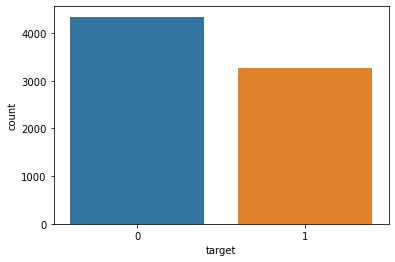

In [24]:
# Посмотрим теперь на распределение целевого признака 'target'
warnings.filterwarnings("ignore")
sns.countplot(y)

In [ ]:
# Данные не выглядят несбалансированными, так что технологии балансировки опускаем

In [166]:
# создаём список незначимых слов и пунктуации
stop = set(STOPWORDS)
punctuation = list(string.punctuation)
stop.update(punctuation)

In [167]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [263]:
# определяем ф-цию для грамотной лемматизации текста
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            # определяем синтаксическую и семантическую информацию, банк лингвистических деревьев
            # расшифровка всех возможных значений тут: www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
            pos = pos_tag([i.strip()])
            # 2-й пар-р лемматизатора - POS тэг, помогающий улучшить качество лемматизации
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return " ".join(final_text)

In [50]:
# пример, как выглядит применение ф-ции 'pos_tag'
pos_tag([X.iloc[0].split()[1].strip()])

[('Deeds', 'NNS')]

In [169]:
# применяем лемматизацию ко всему набору данных
X = X.apply(lemmatize_words)

# 2. Трансформация текста

### 2.1 Трансформация BOW и TF-IDF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 1)

In [171]:
# Подход №1. Bag-of-words (м-ца, где элемент i,j: сколько раз каждый токен j встречался в документе i)

# Инициализируем модуль CountVectorizer
CV = CountVectorizer()
# Составляем словарь из X_train
CV.fit(X_train)
# Размер полученного словаря
print("Словарь состоит из",len(CV.vocabulary_),"слов")
# переводим текстовые данные в числовые
X_train_cv = CV.transform(X_train)
X_test_cv = CV.transform(X_test)

print('Размер тренировочной выборки:',X_train_cv.shape)
print('Размер тестовой выборки:',X_test_cv.shape)

Словарь состоит из 17747 слов
Размер тренировочной выборки: (6090, 17747)
Размер тестовой выборки: (1523, 17747)


In [74]:
np.unique(X_train_cv.toarray())

array([ 0,  1,  2,  3,  4,  6,  7,  9, 13], dtype=int64)

In [172]:
# Подход №2. TF-IDF (м-ца, где элемент i,j: отношение числа вхождений токена j в документе i к общему числу слов документа i)

# Инициализируем модуль TfidfVectorizer
TF = TfidfVectorizer()
# Составляем словарь из X_train
TF.fit(X_train)
# Размер полученного словаря
print("Словарь состоит из",len(TF.vocabulary_),"слов")
# переводим текстовые данные в числовые
X_train_tf = TF.transform(X_train)
X_test_tf = TF.transform(X_test)

print('Размер тренировочной выборки:',X_train_tf.shape)
print('Размер тестовой выборки:',X_test_tf.shape)

Словарь состоит из 17747 слов
Размер тренировочной выборки: (6090, 17747)
Размер тестовой выборки: (1523, 17747)


### 2.2 Word Embedding

In [185]:
# Need to load the large model (lg) to get the vectors
# Есть также малая модель 'en_core_web_sm' и средняя 'en_core_web_md'
# gensim - альтернативный питоновский модуль
nlp = spacy.load('en_core_web_lg')

In [186]:
%%time
# combine all the word vectors into a single document vector
# by AVERAGING the vectors for each word in the document.
# So, the average document vector:
with nlp.disable_pipes():
    vectors = np.array([nlp(text).vector for text in X])

In [189]:
# embedding size (здесь 300) - это просто веса в скрытом слое нейронки, которые
# возникают в ходе вычисления вероятностей принадлежности слова к словам словаря
# если в документе более одного слова - берутся средние значения для каждого веса 
vectors.shape

(7613, 300)

In [201]:
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(vectors, y, test_size = 0.2 , random_state = 1)

# 3. Построение моделей

### 3.1 Определение функций

In [205]:
# Ф-ЦИЯ ПОДБОРА ГИПЕРПАРАМЕТРОВ МОДЕЛИ

# model - модель, которую будем тюнить
# tuned_parameters - сетка гиперпараметров, по которым будем осуществлять подбор
def best_model(model,tuned_parameters,X_train,y_train,X_test,y_test,score = "f1",cv = 0):
    print("# Tuning hyper-parameters for %s" % score)
    print()
    if cv > 0:
        clf = GridSearchCV(model, tuned_parameters,n_jobs=-1, scoring='%s' % score, cv=cv)
    else:
        clf = GridSearchCV(model, tuned_parameters,n_jobs=-1, scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    return clf.best_params_

In [174]:
# Ф-ЦИЯ ВИЗУАЛИЗАЦИИ КЛАССИФИКАТОРА

# Визуализируем результат работы классификатора - слова, вносящие максимальный вклад
def visualize_coefficients(classifier, feature_names,coef = None, n_top_features=30):
    # get coefficients with large absolute values
    # здесь на вход ф-ции поступит ужи обученный классификатор
    if coef is None:
        # ravel() преобразует неодномерный np-array в одномерный
        coef = classifier.coef_.ravel()
    # список индексов отсортированных коэффициентов
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    # Объединяем 2 вышесозданных списка индексов в один список
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [181]:
# Ф-ЦИЯ ПРЕДСКАЗАНИЯ

def fitModel(model,x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test):
    start_time = time.time()
    lr = model
    lr.fit(x_train, y_train)
    fit_time = round(time.time() - start_time,0)
    print("---time_fit model %s seconds ---" % (fit_time))
    preds = lr.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    report = classification_report(y_test,preds,target_names = ['0','1'])
    
    cm_1 = confusion_matrix(y_test,preds)
    cm_1 = pd.DataFrame(cm_1, index=[0,1], columns=[0,1])
    cm_1.index.name = 'Actual'
    cm_1.columns.name = 'Predicted'
    plt.figure(figsize = (10,10))
    sns.heatmap(cm_1,cmap= "Blues",annot = True, fmt='')
    return {'model':lr,'f1_score':f1,'accuracy_score':accuracy,'report':report,'time_fit':fit_time}

### 3.2 Модель LogisticRegression

#### 3.2.1 результаты при трансформации Bag-of-words

In [176]:
%%time
parameters = [{'penalty':['l2'], "solver":['newton-cg', 'lbfgs', 'liblinear'],
                'C': [0.1, 1, 10, 100, 1000]},
              {'penalty':['none'], "solver":['newton-cg', 'lbfgs', 'liblinear'],
                'C': [0.1, 1, 10, 100, 1000]}]
best_params_LR = best_model(LogisticRegression(),parameters,X_train=X_train_cv,
                            y_train=y_train,y_test=y_test,X_test=X_test_cv,score = "accuracy")

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

Grid scores on development set:

0.791 (+/-0.013) for {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.791 (+/-0.013) for {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.791 (+/-0.013) for {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.798 (+/-0.005) for {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.798 (+/-0.005) for {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.797 (+/-0.007) for {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.789 (+/-0.016) for {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.789 (+/-0.017) for {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.788 (+/-0.016) for {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.782 (+/-0.016) for {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.781 (+/-0.017) for {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.782 (+/-0.016) for {'C': 100, 'penalty': 'l2', 'solver': 'lib

---time_fit model 0.0 seconds ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

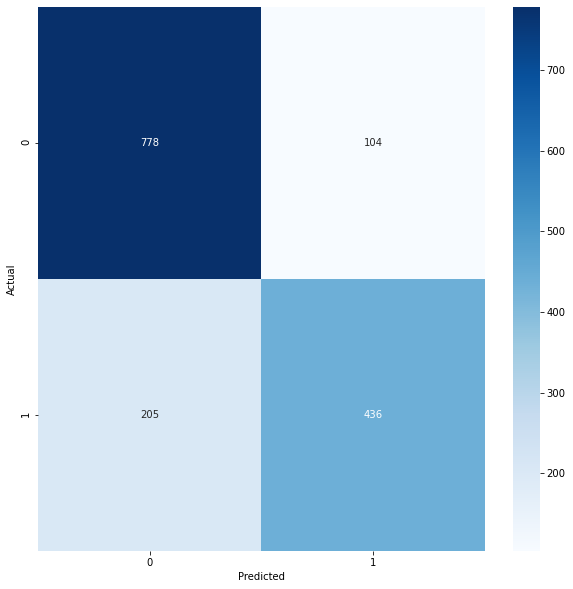

In [182]:
# Возьмем оптимально подобранные гиперпараметры выше и запустим на них ф-цию предсказания
bestmod = fitModel(LogisticRegression(C=best_params_LR['C'],solver = best_params_LR['solver'],penalty=best_params_LR['penalty']),
                   x_train=X_train_cv,y_train=y_train,x_test=X_test_cv,y_test=y_test)
# bestmod - уже обученная модель
#visualize_coefficients(bestmod['model'], CV.get_feature_names())
best_params_of_all_models = []
best_params_of_all_models.append(bestmod)

In [183]:
best_params_of_all_models[0]['accuracy_score']

0.7971109652002626

#### 3.2.2 результаты при трансформации TF-IDF

In [116]:
%%time
parameters = [{'penalty':['l2'], "solver":['newton-cg', 'lbfgs', 'liblinear'],
                'C': [0.1, 1, 10, 100, 1000]},
              {'penalty':['none'], "solver":['newton-cg', 'lbfgs', 'liblinear'],
                'C': [0.1, 1, 10, 100, 1000]}]
best_params_LR = best_model(LogisticRegression(),parameters,X_train=X_train_tf,
                            y_train=y_train,y_test=y_test,X_test=X_test_tf,score = "accuracy")

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

Grid scores on development set:

0.700 (+/-0.009) for {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.700 (+/-0.009) for {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.701 (+/-0.010) for {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.790 (+/-0.010) for {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.790 (+/-0.010) for {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.790 (+/-0.010) for {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.795 (+/-0.016) for {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.795 (+/-0.015) for {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.795 (+/-0.015) for {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.784 (+/-0.013) for {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.784 (+/-0.012) for {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.784 (+/-0.013) for {'C': 100, 'penalty': 'l2', 'solver': 'li

---time_fit model 0.23715591430664062 seconds ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

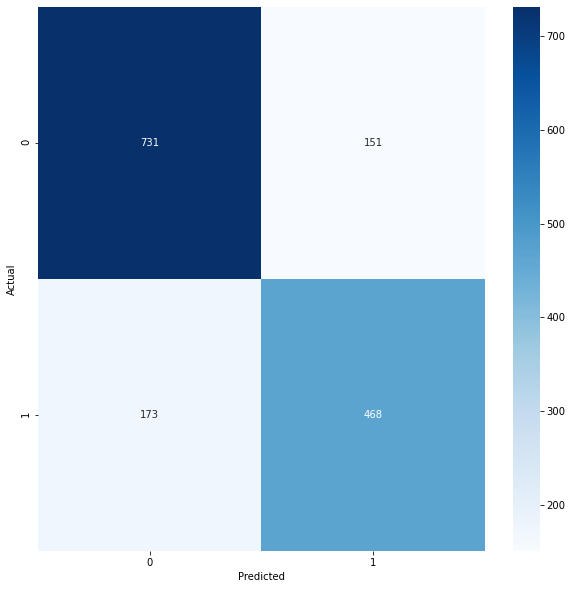

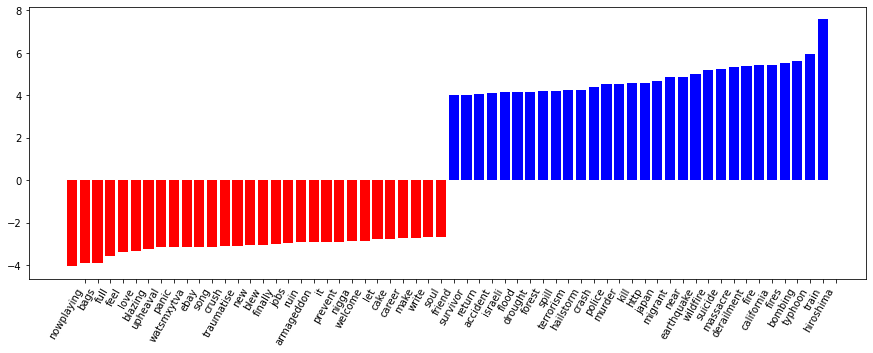

In [117]:
# Возьмем оптимально подобранные гиперпараметры выше и запустим на них ф-цию предсказания
bestmod = fitModel(LogisticRegression(C=best_params_LR['C'],solver = best_params_LR['solver'],penalty=best_params_LR['penalty']),
                   x_train=X_train_tf,y_train=y_train,x_test=X_test_tf,y_test=y_test)
# bestmod - уже обученная модель
visualize_coefficients(bestmod['model'], CV.get_feature_names())
best_params_of_all_models_TF = []
best_params_of_all_models_TF.append(bestmod)

In [118]:
best_params_of_all_models_TF[0]['accuracy_score']

0.7872619829284307

#### 3.2.3 Результаты трансформации word embedding

In [254]:
%%time
parameters = [{'penalty':['l2'], "solver":['newton-cg', 'lbfgs', 'liblinear'],
                'C': [0.1, 1, 10, 100, 1000]},
              {'penalty':['none'], "solver":['newton-cg', 'lbfgs', 'liblinear'],
                'C': [0.1, 1, 10, 100, 1000]}]
best_params_LR = best_model(LogisticRegression(),parameters,X_train=X_train_emb,
                            y_train=y_train_emb,y_test=y_test_emb,X_test=X_test_emb,score = "accuracy")

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

Grid scores on development set:

0.788 (+/-0.010) for {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.788 (+/-0.010) for {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.787 (+/-0.011) for {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.788 (+/-0.011) for {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.788 (+/-0.011) for {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.788 (+/-0.011) for {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.783 (+/-0.014) for {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.783 (+/-0.012) for {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.783 (+/-0.013) for {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.781 (+/-0.011) for {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.782 (+/-0.012) for {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.781 (+/-0.011) for {'C': 100, 'penalty': 'l2', 'solver': 'lib

---time_fit model 1.0 seconds ---


<IPython.core.display.Javascript object>

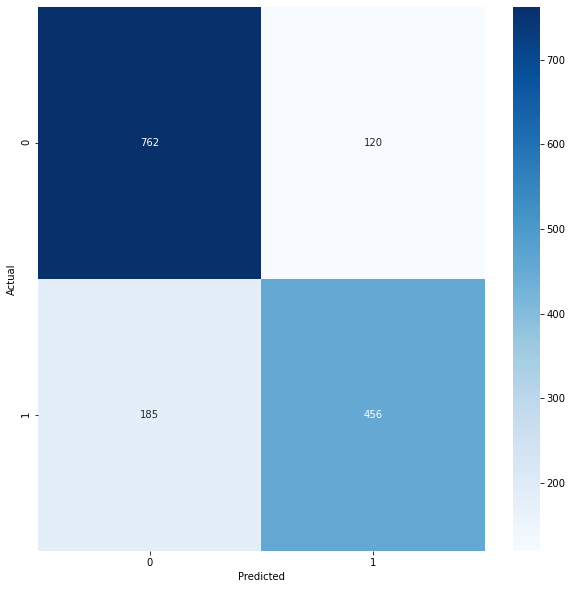

In [255]:
# Возьмем оптимально подобранные гиперпараметры выше и запустим на них ф-цию предсказания
bestmod = fitModel(LogisticRegression(C=best_params_LR['C'],solver = best_params_LR['solver'],penalty=best_params_LR['penalty']),
                   x_train=X_train_emb,y_train=y_train_emb,x_test=X_test_emb,y_test=y_test_emb)

In [211]:
# Будем использовать эту модель трансформации для оценки последующих моделей
best_params_of_all_models = []
best_params_of_all_models.append(bestmod)

In [256]:
bestmod['f1_score']

0.7493837304847986

#### Сделаем предсказание на выборке KAGGLE

In [257]:
df = pd.read_csv('Data/DisasterTweets/test.csv', sep=',', skipinitialspace=True)

In [259]:
df.head(2)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."


In [258]:
df_sample = pd.read_csv('Data/DisasterTweets/sample_submission.csv', sep=',', skipinitialspace=True)
df_sample.head(2)

,id,target
0,0,0
1,2,0


In [261]:
%%time
X_for_pred = df.text
# применяем лемматизацию
X_for_pred = X_for_pred.apply(lemmatize_words)

Wall time: 37.2 s


In [262]:
X_for_pred.head()

0                            happen terrible car crash
1    heard #earthquake different cities, stay safe ...
2    forest fire spot pond, geese flee across stree...
3             apocalypse lighting. #spokane #wildfires
4                typhoon soudelor kill 28 china taiwan
Name: text, dtype: object

In [271]:
%%time
# combine all the word vectors into a single document vector
# by AVERAGING the vectors for each word in the document.
# So, the average document vector:
with nlp.disable_pipes():
    X_vec = np.array([nlp(text).vector for text in X_for_pred])

Wall time: 59.1 s


In [272]:
preds = bestmod['model'].predict(X_vec)

In [287]:
pred_final = pd.DataFrame(np.array([df['id'].values, preds]).transpose(),columns=[['id','target']])

In [288]:
pred_final.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [289]:
pred_final.to_csv('Data/DisasterTweets/Pred1.csv',sep=',',header=True,index=False)

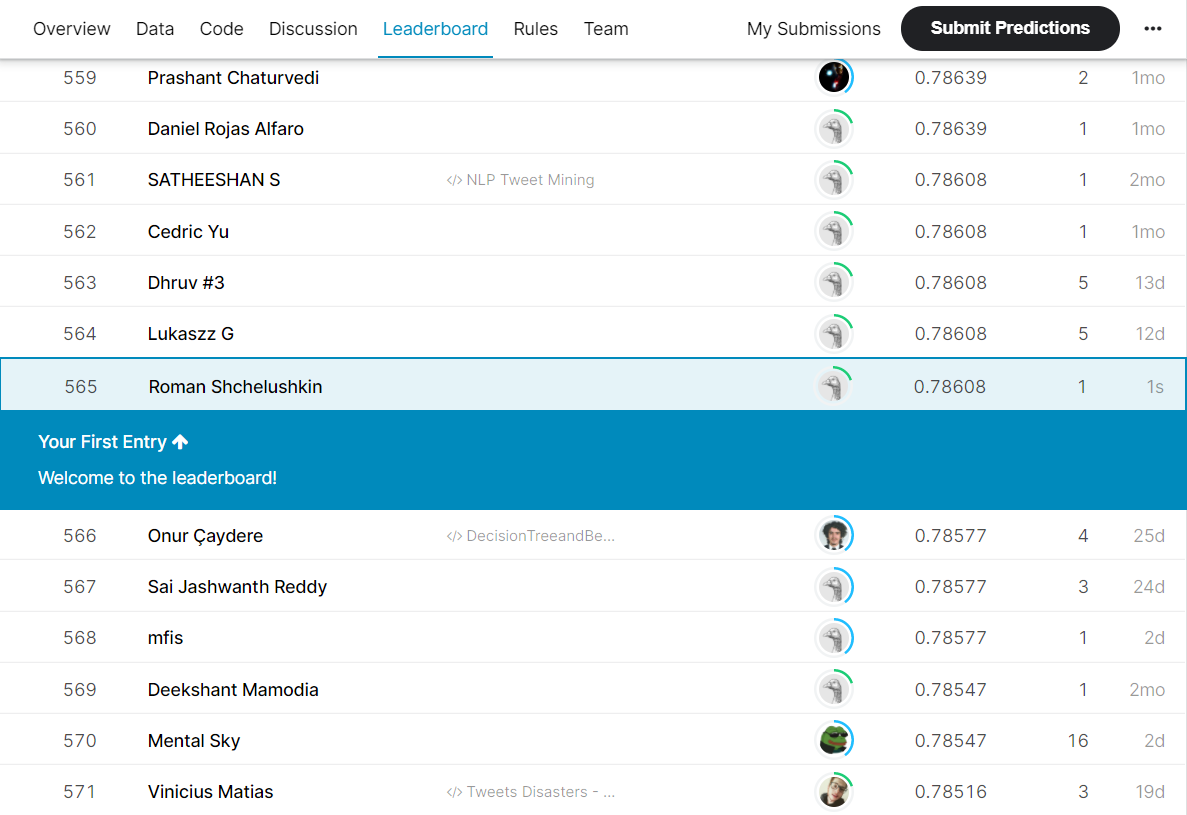

In [293]:
Image("Data/DisasterTweets/Kaggle_compet.PNG")

### 3.3 Модель SVC

In [ ]:
%%time
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
              {'kernel': ['poly'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]}]
best_params_SVC = best_model(SVC(),parameters,X_train=X_train_emb,
                            y_train=y_train_emb,y_test=y_test_emb,X_test=X_test_emb,score = "accuracy")

In [ ]:
# Возьмем оптимально подобранные гиперпараметры выше и запустим на них ф-цию предсказания
bestmod = fitModel(SVC(C=best_params_SVC['C'],gamma = best_params_SVC['gamma'],kernel=best_params_SVC['kernel']),
                   x_train=X_train_emb,y_train=y_train_emb,x_test=X_test_emb,y_test=y_test_emb)

best_params_of_all_models.append(bestmod)

In [ ]:
bestmod['accuracy_score']

### 3.4 Модель DecisionTreeClassifier

In [220]:
%%time
parameters = [{'criterion':['gini', 'entropy'],'splitter':['best', 'random'],'max_depth':[20,30,40,50,80],
               'max_features':[None,'auto'],'class_weight':['balanced',None]}]
best_params_DTC = best_model(DecisionTreeClassifier(),parameters,X_train=X_train_emb,
                            y_train=y_train_emb,y_test=y_test_emb,X_test=X_test_emb,score = "accuracy")

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 50, 'max_features': None, 'splitter': 'random'}

Grid scores on development set:

0.685 (+/-0.017) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'splitter': 'best'}
0.676 (+/-0.020) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'splitter': 'random'}
0.670 (+/-0.011) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'splitter': 'best'}
0.650 (+/-0.038) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'splitter': 'random'}
0.685 (+/-0.017) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'splitter': 'best'}
0.679 (+/-0.020) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'sp

---time_fit model 1.0 seconds ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

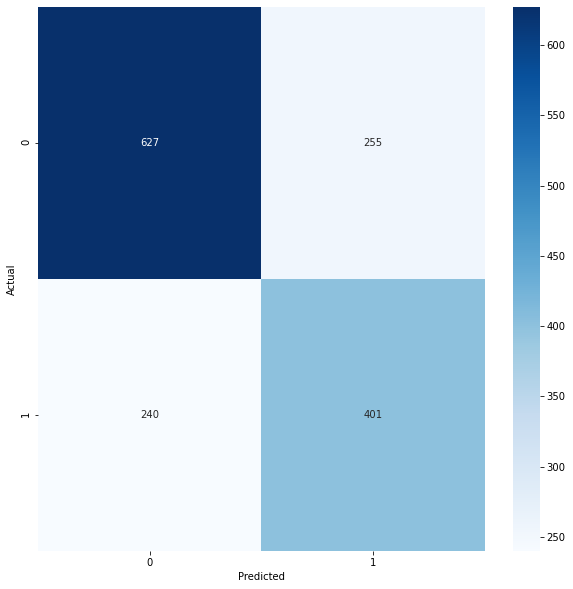

In [222]:
# Возьмем оптимально подобранные гиперпараметры выше и запустим на них ф-цию предсказания
bestmod = fitModel(DecisionTreeClassifier(criterion=best_params_DTC['criterion'],splitter=best_params_DTC['splitter'],
                                        max_depth=best_params_DTC['max_depth'],max_features=best_params_DTC['max_features'],
                                        class_weight=best_params_DTC['class_weight']),
                   x_train=X_train_emb,y_train=y_train_emb,x_test=X_test_emb,y_test=y_test_emb)

best_params_of_all_models.append(bestmod)

In [223]:
bestmod['accuracy_score']

0.6749835850295469

### 3.5 Модель SGDClassifier

In [224]:
%%time
parameters = [{'loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
               'max_iter' : [100,1000,2000],'tol':[10**(-3),10**(-2),10**(-4)]}]
best_params_SGD = best_model(SGDClassifier(),parameters,X_train=X_train_emb,
                            y_train=y_train_emb,y_test=y_test_emb,X_test=X_test_emb,score = "accuracy")

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'loss': 'log', 'max_iter': 1000, 'tol': 0.0001}

Grid scores on development set:

0.782 (+/-0.026) for {'loss': 'hinge', 'max_iter': 100, 'tol': 0.001}
0.771 (+/-0.029) for {'loss': 'hinge', 'max_iter': 100, 'tol': 0.01}
0.774 (+/-0.035) for {'loss': 'hinge', 'max_iter': 100, 'tol': 0.0001}
0.773 (+/-0.021) for {'loss': 'hinge', 'max_iter': 1000, 'tol': 0.001}
0.768 (+/-0.027) for {'loss': 'hinge', 'max_iter': 1000, 'tol': 0.01}
0.777 (+/-0.023) for {'loss': 'hinge', 'max_iter': 1000, 'tol': 0.0001}
0.781 (+/-0.010) for {'loss': 'hinge', 'max_iter': 2000, 'tol': 0.001}
0.772 (+/-0.027) for {'loss': 'hinge', 'max_iter': 2000, 'tol': 0.01}
0.784 (+/-0.014) for {'loss': 'hinge', 'max_iter': 2000, 'tol': 0.0001}
0.776 (+/-0.023) for {'loss': 'log', 'max_iter': 100, 'tol': 0.001}
0.765 (+/-0.033) for {'loss': 'log', 'max_iter': 100, 'tol': 0.01}
0.783 (+/-0.008) for {'loss': 'log', 'max_iter': 100, 'tol'

---time_fit model 1.0 seconds ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

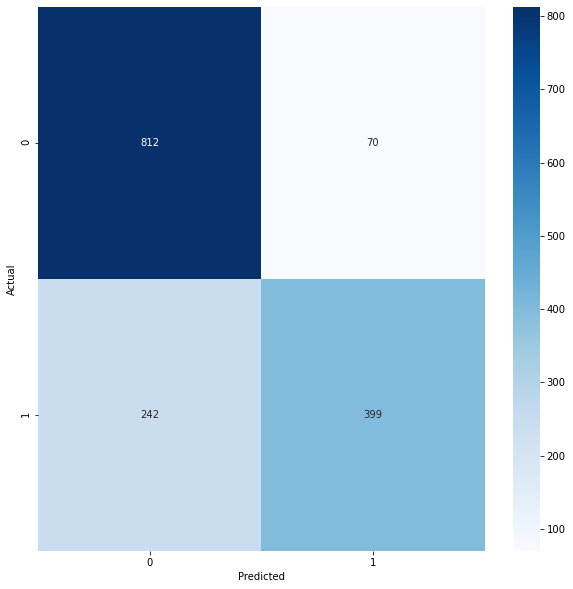

In [225]:
# Возьмем оптимально подобранные гиперпараметры выше и запустим на них ф-цию предсказания
bestmod = fitModel(SGDClassifier(loss=best_params_SGD['loss'],max_iter=best_params_SGD['max_iter'],tol=best_params_SGD['tol']),
                   x_train=X_train_emb,y_train=y_train_emb,x_test=X_test_emb,y_test=y_test_emb)

best_params_of_all_models.append(bestmod)

In [226]:
bestmod['accuracy_score']

0.7951411687458962

### 3.6 Модель RandomForestClassifier

---time_fit model 12.0 seconds ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

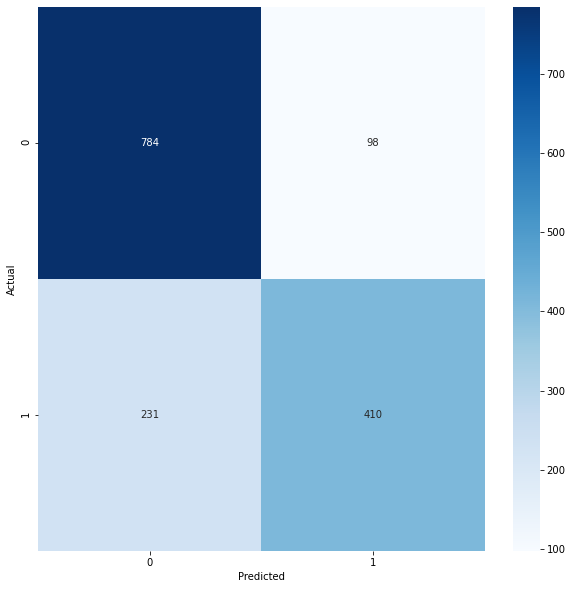

In [229]:
# Возьмем оптимально подобранные гиперпараметры выше и запустим на них ф-цию предсказания
bestmod = fitModel(RandomForestClassifier(n_estimators=50,criterion='entropy',random_state=0),
                   x_train=X_train_emb,y_train=y_train_emb,x_test=X_test_emb,y_test=y_test_emb)

best_params_of_all_models.append(bestmod)

In [233]:
bestmod['f1_score']

0.7136640557006092

### 3.7 Модель XGB Classifier

In [252]:
%%time
XGB = xgb.XGBClassifier()
XGB.fit(X_train_emb, y_train_emb)
pred_emb = XGB.predict(X_test_emb)
XGB_accuracy = accuracy_score(y_test_emb, pred_emb)
 
print("Accuracy: ",XGB_accuracy)

[20:46:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.7997373604727511
Wall time: 50.7 s
